# Post-COVID Evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *
from plotnine import *

In [82]:
df = load_predictions('post-covid')

In [83]:
# df.value = df.value.round()

In [84]:
# df = df[df.forecast_date != '2023-12-28']

In [85]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm2' : 'LightGBM-Old',
    'lightgbm23' : 'LightGBM',
    'lightgbm_skip': 'LightGBM-Skip',
    'lightgbm_retrain': 'LightGBM-Retrain',
    'tsmixer' : 'TSMixer',
    'KIT-hhh4' : 'hhh4',
    'KIT-hhh4_all_data': 'hhh4_all_data',
    'KIT-hhh4_all_data_skip': 'hhh4_all_data_skip',
    'KIT-baseline' : 'Nowcast',
    'baseline' : 'Baseline'
}

In [86]:
model_colors = {
    "LightGBM": "#B30000",
    "TSMixer": "#E69F00",
    "LightGBM-Retrain": "#999999",
    "Nowcast": "#56B4E9",
    "hhh4_all_data": "#F0E442",
    "Ensemble": "#009E73",
    "LightGBM-Old": "#60D1B3",
    "Baseline": "#80471C",
    "hhh4": "#3C4AAD",
    "hhh4_all_data_skip": "#CC79A7",
    "LightGBM-Skip": "#000000"
}

In [87]:
df.model = df.model.replace(model_names)

In [88]:
df.model.unique()

array(['tsmixer_precov', 'LightGBM-Old', 'tsmixer_retrain',
       'LightGBM-Skip', 'LightGBM-Retrain', 'LightGBM', 'Baseline',
       'KIT-persistence', 'lightgbm', 'TSMixer', 'hhh4_all_data',
       'hhh4_all_data_skip', 'Ensemble', 'hhh4', 'lightgbm_precov'],
      dtype=object)

In [89]:
df = df[~df.model.str.contains('skip', case=False)]

In [90]:
df = df[~df.model.str.contains('old', case=False)]

In [91]:
df = df[df.model != 'lightgbm']

In [92]:
df = df[df.forecast_date != '2023-12-28']

In [33]:
df = df[df.target_end_date.between('2023-01-04', '2024-09-15')].reset_index(drop=True)

In [76]:
df = df[df.target_end_date.between('2023-01-04', '2024-03-31')].reset_index(drop=True)

In [93]:
df = df[df.target_end_date.between('2023-01-04', '2024-08-15')].reset_index(drop=True)

# Compute scores

#### National level

In [94]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,398.813442,206.306628,537.095103,1142.215172,0.338462,0.946154
1,tsmixer_retrain,517.740891,365.132462,277.523819,1160.397172,0.600000,0.946154
2,lightgbm_precov,427.354728,52.860456,706.240465,1186.455649,0.284615,0.930769
3,LightGBM-Retrain,418.159395,45.081107,773.827160,1237.067663,0.600000,0.923077
4,TSMixer,452.693546,361.852248,435.814780,1250.360574,0.361538,0.884615
5,LightGBM,400.623381,37.356413,815.701705,1253.681498,0.507692,0.923077
6,hhh4_all_data,471.014031,571.164541,482.704082,1524.882653,0.294643,0.839286
7,hhh4,371.241758,533.070330,679.641758,1583.953846,0.253846,0.692308
8,KIT-persistence,752.200330,825.656044,224.376923,1802.233297,0.623077,0.900000
9,Baseline,480.801698,15.597190,1692.607728,2189.006616,0.196721,0.500000


In [34]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,379.725849,188.535785,493.019263,1061.280897,0.333333,0.953333
1,LightGBM-Retrain,390.738522,60.592784,683.954748,1135.286054,0.586667,0.926667
2,LightGBM,383.276218,45.634760,723.740799,1152.651777,0.506667,0.933333
3,TSMixer,429.783552,316.963840,414.635035,1161.382427,0.373333,0.900000
4,hhh4,353.552381,474.912381,616.855238,1445.320000,0.260000,0.726667
5,hhh4_all_data,471.014031,571.164541,482.704082,1524.882653,0.294643,0.839286
6,Baseline,454.529829,13.400402,1632.324950,2100.255181,0.197183,0.485915


In [35]:
# evaluate_models(df, 'national', by_horizon=True)

#### Age groups

In [95]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,90.185163,54.989568,81.936480,227.111210,0.438462,0.923077
1,lightgbm_precov,90.172711,36.111914,101.347381,227.632005,0.373077,0.825641
2,LightGBM-Retrain,72.869146,36.874494,135.368490,245.112130,0.352564,0.826923
3,LightGBM,71.454010,33.250030,146.857506,251.561546,0.330769,0.797436
4,tsmixer_retrain,104.105104,80.526423,77.110948,261.742475,0.469231,0.858974
5,hhh4,110.194139,103.092857,63.489011,276.776007,0.460256,0.917949
6,TSMixer,95.132309,72.895525,111.621319,279.649153,0.367949,0.776923
7,hhh4_all_data,128.135629,89.792730,66.441114,284.369473,0.513393,0.947917
8,KIT-persistence,115.816722,159.468498,58.834249,334.119469,0.458974,0.821795
9,Baseline,103.055777,8.002732,237.393638,348.452147,0.289617,0.657104


In [36]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,85.778754,50.509864,78.140914,214.429533,0.433333,0.927778
1,LightGBM-Retrain,68.138533,36.680470,126.000808,230.819810,0.341111,0.818889
2,LightGBM,67.579219,32.582348,140.133366,240.294934,0.316667,0.788889
3,hhh4,105.287302,92.259524,58.003492,255.550317,0.495556,0.927778
4,TSMixer,90.202557,66.080113,115.522073,271.804742,0.362222,0.764444
5,hhh4_all_data,128.135629,89.792730,66.441114,284.369473,0.513393,0.947917
6,Baseline,97.020523,7.764923,239.297284,344.082730,0.272300,0.625587


In [12]:
# evaluate_models(df, 'age', by_horizon=True)

In [13]:
# evaluate_models(df, 'age', by_age=True)

# Plots

In [37]:
df_national = evaluate_models(df, 'national')
df_age = evaluate_models(df, 'age')

In [38]:
df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

In [39]:
df_wide['level'] = pd.Categorical(df_wide['level'], categories=['national', 'age'], ordered=True)

In [40]:
df_long = pd.melt(df_wide, id_vars=['level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [41]:
# df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


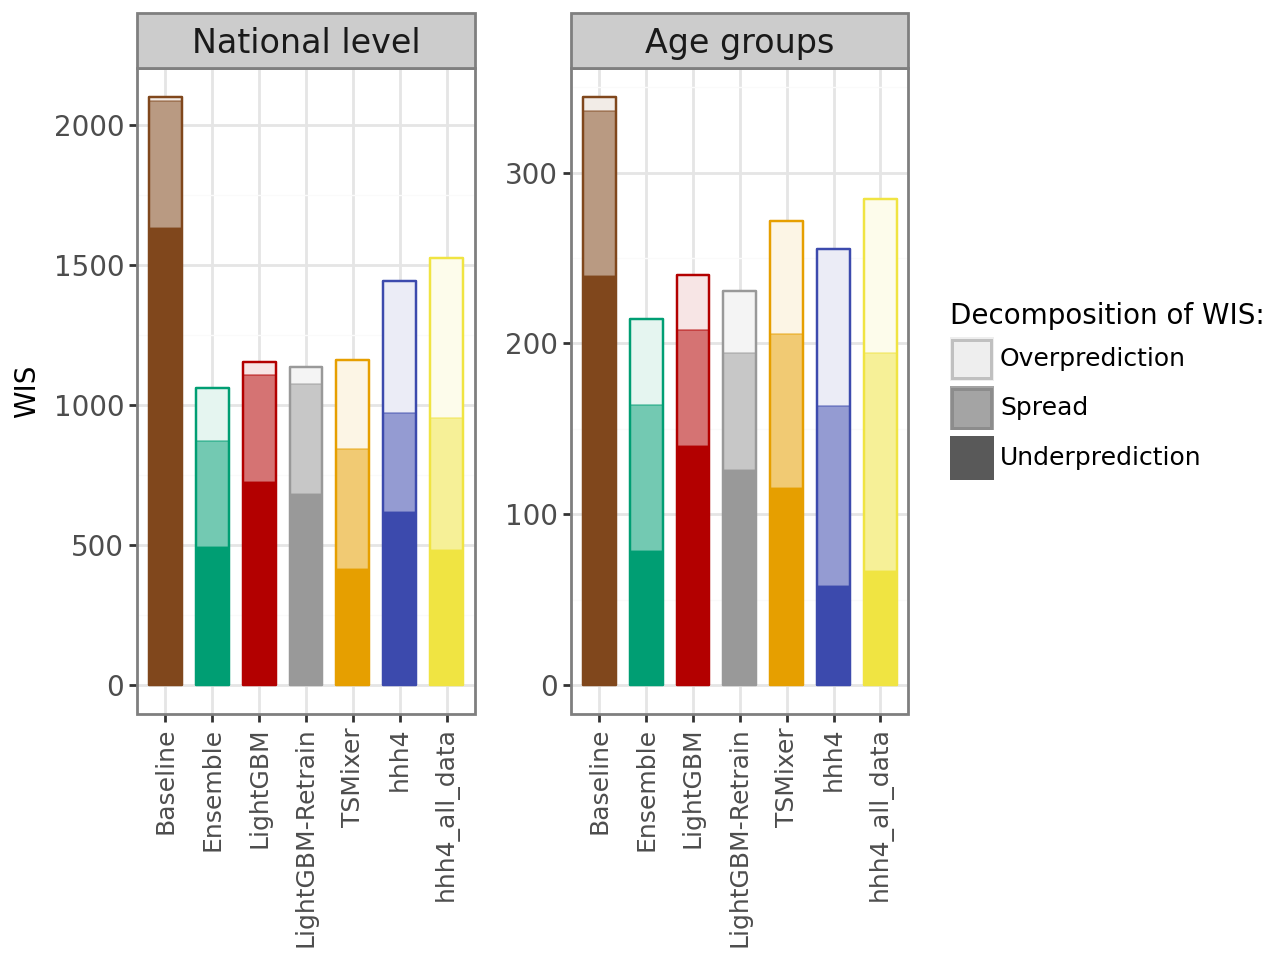

In [55]:
p = (ggplot()
    + facet_wrap('~level', nrow=1, scales='free_y', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
    + geom_bar(df_long[df_long.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7, show_legend=False)
    + geom_bar(df_long[df_long.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric', color='model'), size=0.1, stat='identity', width=0.7, 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_color_manual(values=model_colors)
    + scale_fill_manual(values=model_colors)
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
    #+ coord_flip()
    + theme_bw()
    + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=12),             # Facet title text size
            legend_title=element_text(size=10),           # Legend title text size
            legend_text=element_text(size=9),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),                # Axis text (tick labels) size
            axis_text_y=element_text(size=10),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14))              # Plot title text size)
   )
p

In [56]:
p.save("../figures/wis.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis.pdf


In [46]:
coverage_df = df_national

In [47]:
coverage_df = df_wide

In [48]:
alphas = {"50%": 0.7, "95%": 0.4}

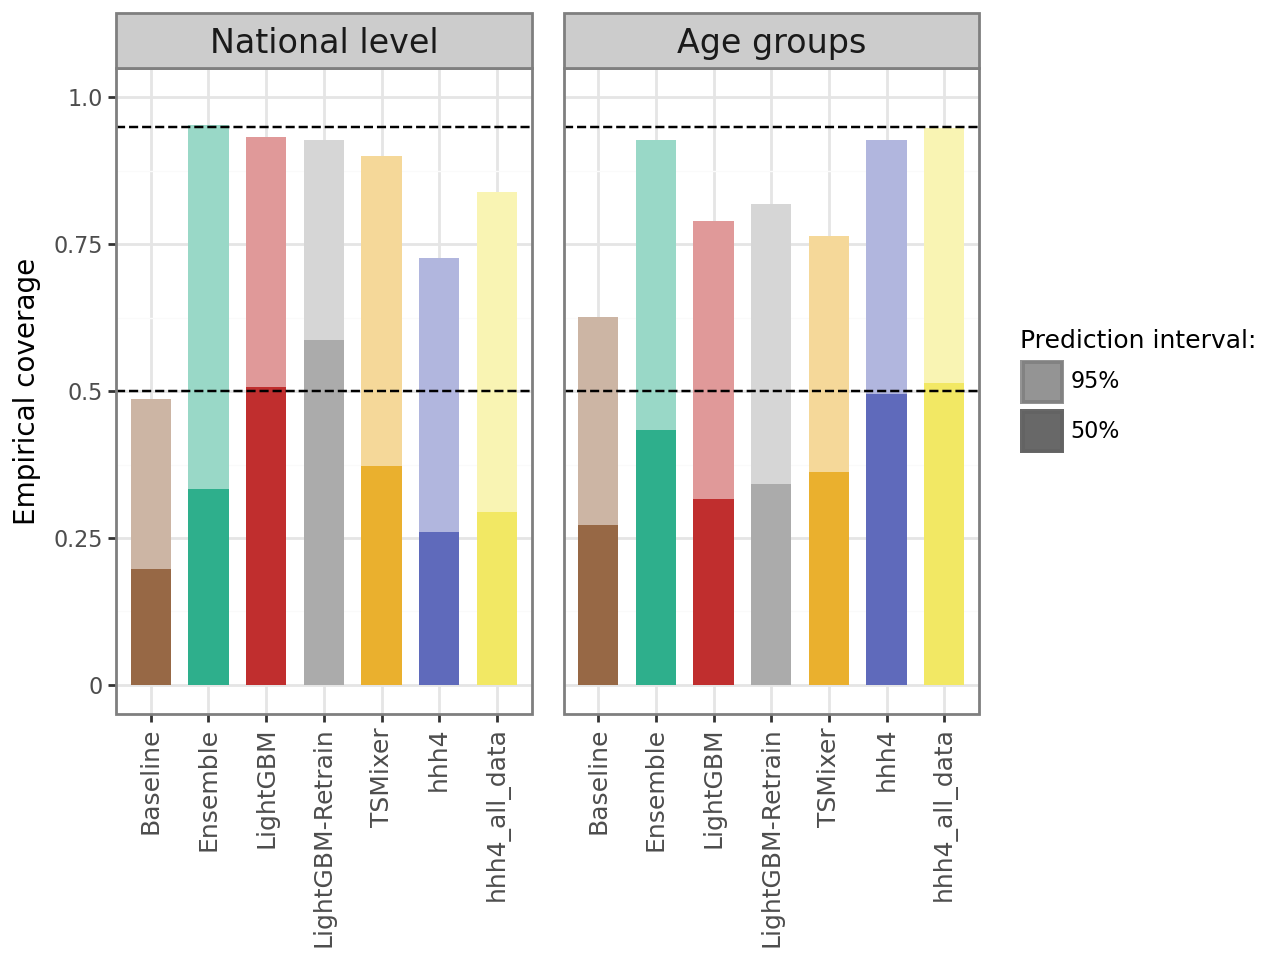

In [52]:
p = (
    ggplot(coverage_df, aes(x='model'))
    + facet_wrap('~level', nrow=1, scales='fixed', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
    + expand_limits(y=1)  # Ensure y-axis starts at 1
    
    # Add columns for 95% and 50% coverage with respective alpha transparency
    + geom_col(aes(y='c95'), width=0.7, fill='white', show_legend={'fill': False})
    + geom_col(aes(y='c95', fill='model', alpha='"95%"'), width=0.7, show_legend={'fill': False})
    + geom_col(aes(y='c50', fill='model', alpha='"50%"'), width=0.7, show_legend={'fill': False})
    
    # Horizontal dashed lines at y = 0.5 and y = 0.95
    + geom_hline(yintercept=[0.5, 0.95], linetype='dashed')
    
    # Customize y-axis labels to display "0" instead of omitting 0
    + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])
    
    # Labels for axes, color, and alpha legend
    + labs(
        x='',
        y="Empirical coverage",
        color="Model",
        alpha="Prediction interval: "
    )
    
    # Conditional color mapping for fill
    + scale_fill_manual(values=model_colors)
    
    # Flip coordinates to make x-axis vertical
    #+ coord_flip()
    
    # Custom alpha levels for each bar transparency
    + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=False))
    
    # Basic theme with customized legend position and alignment
    + theme_bw()
    + theme(
        legend_position='right',
        legend_title_position='top',
        strip_text=element_text(size=12),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_text_x=element_text(size=9, rotation=90, ha="center"),
        axis_text_y=element_text(size=8),
        axis_title=element_text(size=10),
        plot_title=element_text(size=14),
        panel_spacing=0.025
    )
)

# Display the plot
p

In [53]:
p.save("../figures/coverage.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/coverage.pdf


## By horizon

In [19]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [20]:
def plot_scores_by_horizon_and_model(df, level='national'):
    scores = df[df.level==level].copy()
    
    desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_grid(cols='horizon', labeller=lambda x: 'Horizon: ' + str(x))  # Create a facet for each horizon
        # + facet_wrap('~horizon', nrow=4, labeller=lambda x: 'Horizon: ' + str(x))  # Create a facet for each horizon
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


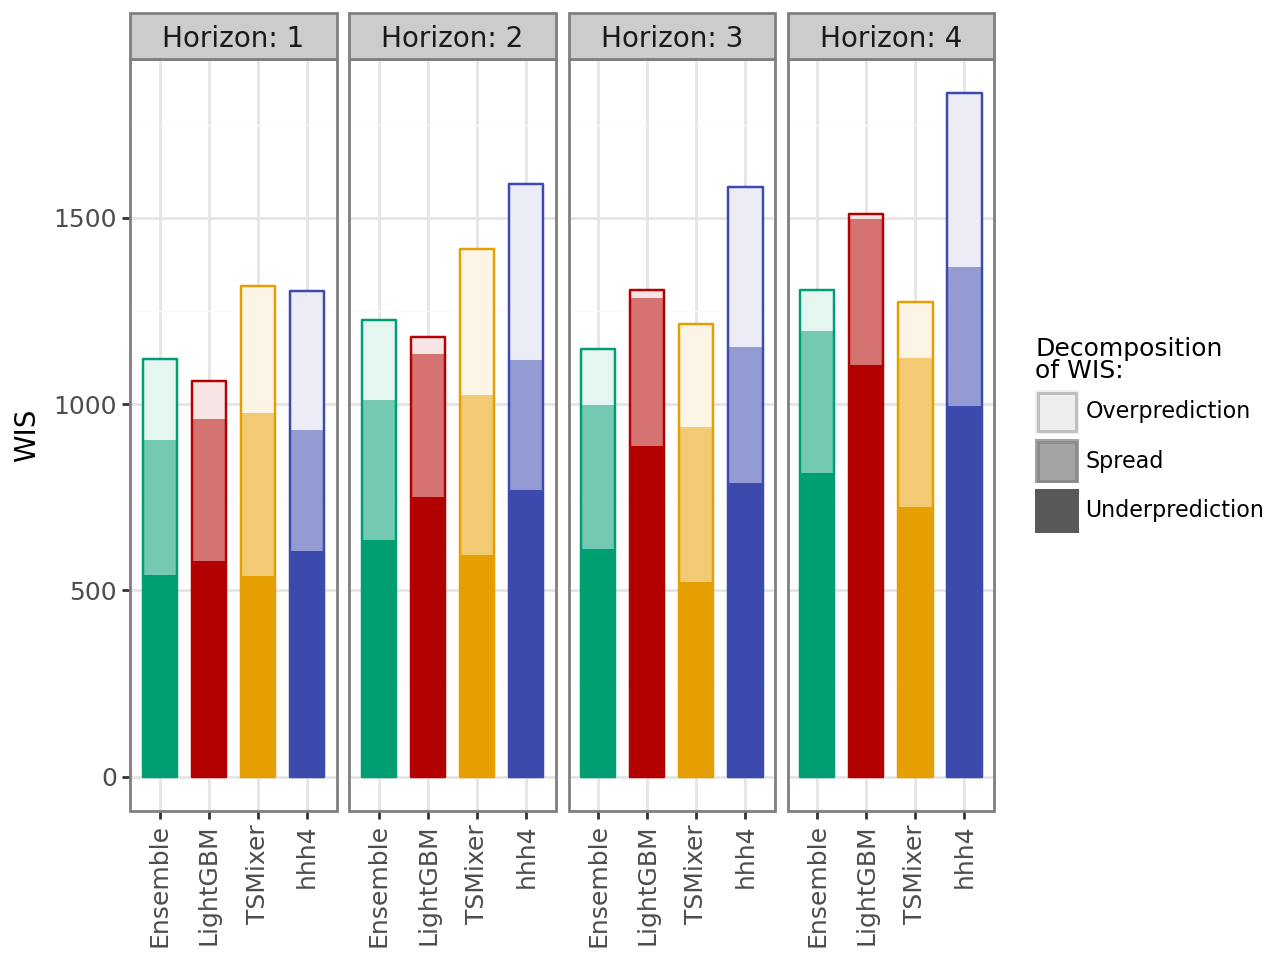

In [21]:
p = plot_scores_by_horizon_and_model(df_long, 'national')
p

In [139]:
p.save("../figures/wis_national_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national_horizon.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


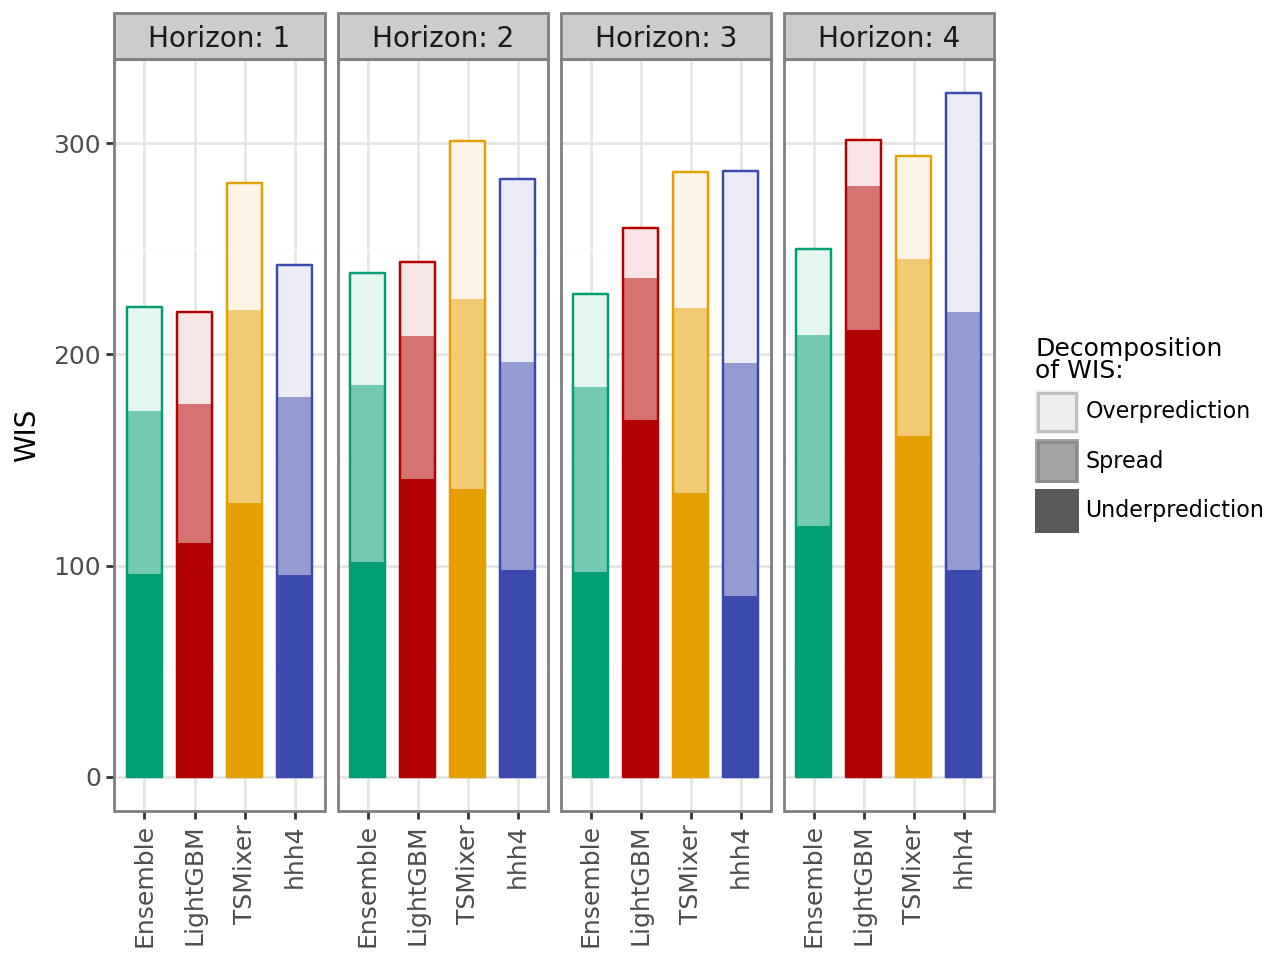

In [22]:
p = plot_scores_by_horizon_and_model(df_long, level='age')
p

In [141]:
p.save("../figures/wis_age_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


## By age group

In [57]:
scores_age = evaluate_models(df, 'age', by_age=True)

In [58]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [59]:
def plot_scores_by_age_group(scores):
    # desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4']
    # scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


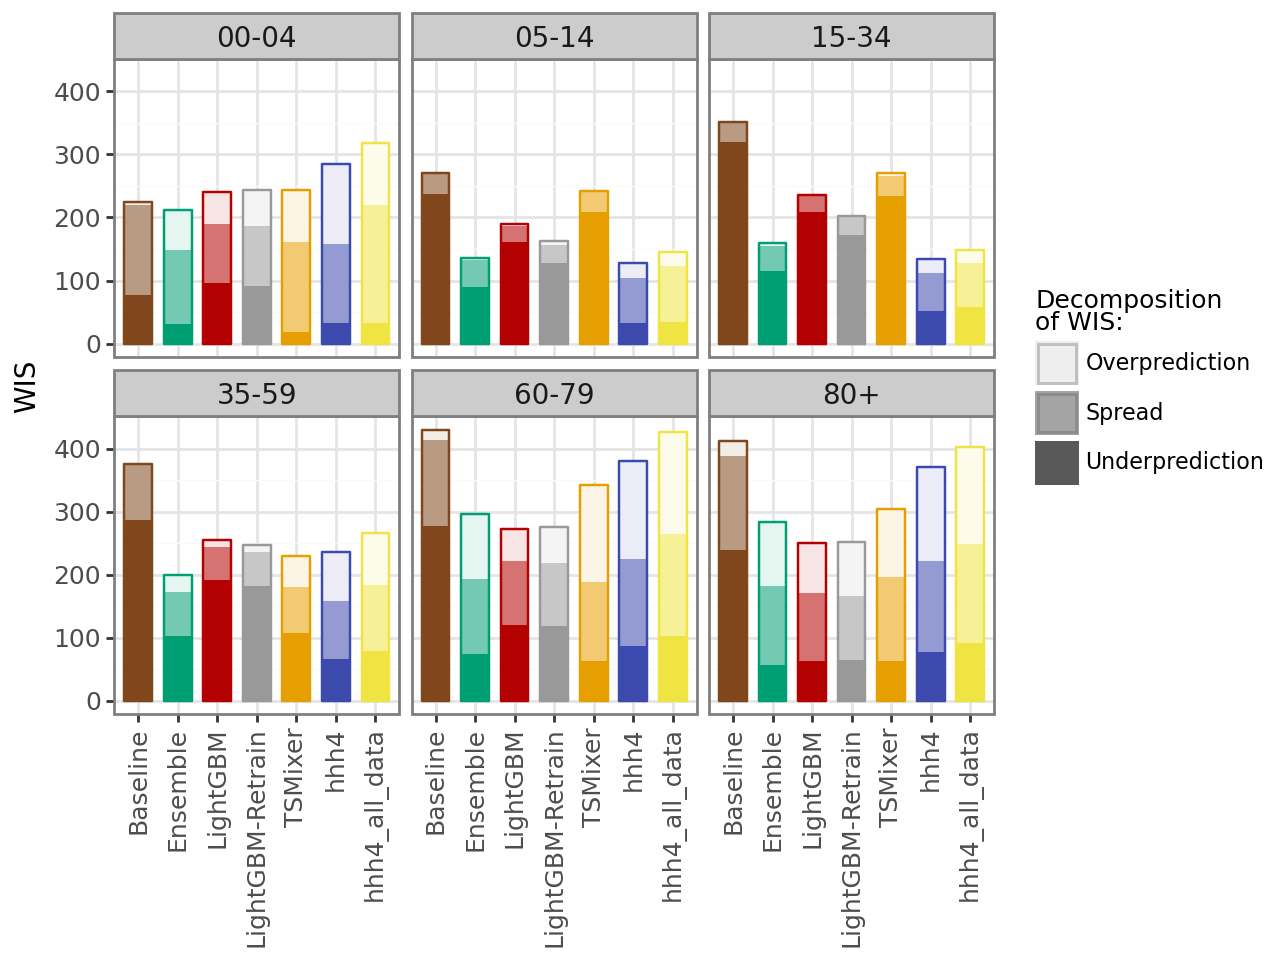

In [60]:
p = plot_scores_by_age_group(scores_age)
p

In [61]:
p.save("../figures/wis_age.pdf", width = 160, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
